# Zero Shot with CLIP on Test Dataset
- See how CLIP performs on predicting an emoji without fine-tuning.
- We check for predicting the correct emoji and how it performs with suggesting K emoji's


In [2]:
# you might want to restart the kernel after installation is complete.
!pip install transformers evaluate docarray pillow datasets seaborn ipywidgets requests jupyter jupyter_client --upgrade --quiet

## 1. Getting Dataset

In [3]:
from datasets import load_dataset, Dataset

In [4]:
test_dataset = load_dataset("vincentclaes/emoji-predictor", split="test")
test_dataset

Using custom data configuration vincentclaes--emoji-predictor-c6a5cac9e16fb34d
Reusing dataset parquet (/root/.cache/huggingface/datasets/vincentclaes___parquet/vincentclaes--emoji-predictor-c6a5cac9e16fb34d/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


Dataset({
    features: ['text', 'label'],
    num_rows: 1587
})

## 2. Get Emojis as Images

/opt/conda/lib/python3.8/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


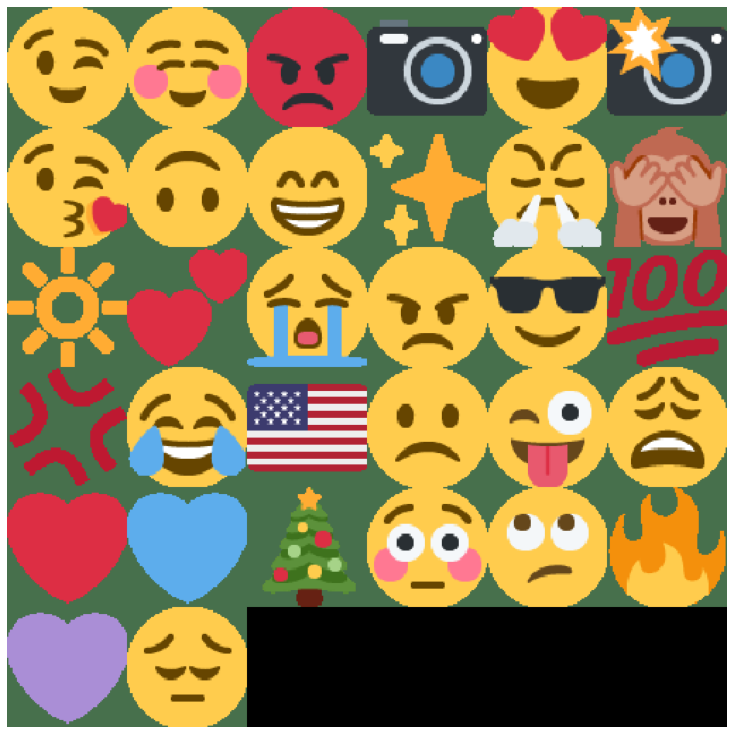

In [5]:
from docarray import DocumentArray

images = DocumentArray.from_files('emojis/*.png')
images.plot_image_sprites()

In [6]:
from PIL import Image

no_features = list(set(test_dataset["label"])) # these are the emoji's we use
emojis_as_images = [Image.open(f"emojis/{i}.png") for i in no_features]


## 3. Pass Test Dataset Throup CLIP

In [7]:
from transformers import CLIPProcessor, CLIPModel
import torch

In [8]:
checkpoint = "openai/clip-vit-base-patch32"
predictions = []
suggestions = []
references = []
SHARDS = 20
K = 4

# not fully understanding this, but with torch.no_grad
# our GPU does not run out of memory.
with torch.no_grad():
    for i in range(SHARDS):
        chunk = test_dataset.shard(num_shards=SHARDS, index=i)
        chunk_text = chunk["text"]
        chunk_label = chunk["label"]
        model = CLIPModel.from_pretrained(checkpoint).to("cuda")
        processor = CLIPProcessor.from_pretrained(checkpoint)
        inputs = processor(text=chunk_text, images=emojis_as_images, return_tensors="pt", padding=True, truncation=True)
        outputs = model(**inputs.to("cuda"))
        # we want the probability for each emoji per sentence.
        logits_per_text = outputs.logits_per_text
        # we take the softmax to get the label probabilities
        probs = logits_per_text.softmax(dim=1)
        
        # take the predictions with the highest probability
        predictions_for_chunk = [torch.argmax(prob).item() for prob in probs]

        # top K number of options
        predictions_suggestions_for_chunk = [torch.topk(prob, K).indices.tolist() for prob in probs]
        # if the label is in the suggestions, take the label else take the first predicted one.
        predictions_suggestions_for_chunk = [x if x in predictions_suggestions_for_chunk[i] else predictions_suggestions_for_chunk[i][0] for i,x in enumerate(chunk_label)]    

        suggestions.extend(predictions_suggestions_for_chunk)
        predictions.extend(predictions_for_chunk)
        references.extend(chunk_label)
        
        print(f"total predictions so far: {len(predictions)}")
        torch.cuda.empty_cache()

/opt/conda/lib/python3.8/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


total predictions so far: 80
total predictions so far: 160
total predictions so far: 240
total predictions so far: 320
total predictions so far: 400
total predictions so far: 480
total predictions so far: 560
total predictions so far: 639
total predictions so far: 718
total predictions so far: 797
total predictions so far: 876
total predictions so far: 955
total predictions so far: 1034
total predictions so far: 1113
total predictions so far: 1192
total predictions so far: 1271
total predictions so far: 1350
total predictions so far: 1429
total predictions so far: 1508
total predictions so far: 1587


## 4. Evaluate Predictions

In [9]:
import evaluate
precision_metric = evaluate.load("precision")
print("""We calculate the precision for prediction the right emoji. 
The following number show the percentage of correctly predicted (TP) 
compared to wrongly + correctly predcted (FP + TP). \n""")

# Micro-averaging will put more emphasis on the common classes in the data set. 
# Rare labels shouldn’t influence the overall precision metric heavily.
precision_for_predictions = precision_metric.compute(references=references, predictions=predictions, average="micro")
print("Precision for the emoji with highest probability:")
print(precision_for_predictions)


We calculate the precision for prediction the right emoji. 
The following number show the percentage of correctly predicted (TP) 
compared to wrongly + correctly predcted (FP + TP). 

Precision for the emoji with highest probability:
{'precision': 0.13358538122243227}


In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def confusion_matrix_emojis(labels, predictions):
    cm = confusion_matrix(labels, predictions)
    # Normalise
    # cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.set(rc={'figure.figsize':(25,25)})
    heatmap = sns.heatmap(cm, annot=True)
    heatmap.set(xlabel='Predicted Labels', ylabel='True Labels')

    img = [plt.imread(f"emojis/{i}.png") for i in no_features]
    tick_labels = heatmap.xaxis.get_ticklabels()
    y_tick_labels = heatmap.yaxis.get_ticklabels()
    for i,im in enumerate(img):
        ib = OffsetImage(im, zoom=.4)
        ib.image.axes = heatmap
        ab_x = AnnotationBbox(ib,
                        tick_labels[i].get_position(),
                        frameon=False,
                        box_alignment=(0.5, 50)
                        )
        ab_y = AnnotationBbox(ib,
                        y_tick_labels[i].get_position(),
                        frameon=False,
                        box_alignment=(3, 0.5)
                        )
        heatmap.add_artist(ab_x)
        heatmap.add_artist(ab_y)

    plt.show(block=False)



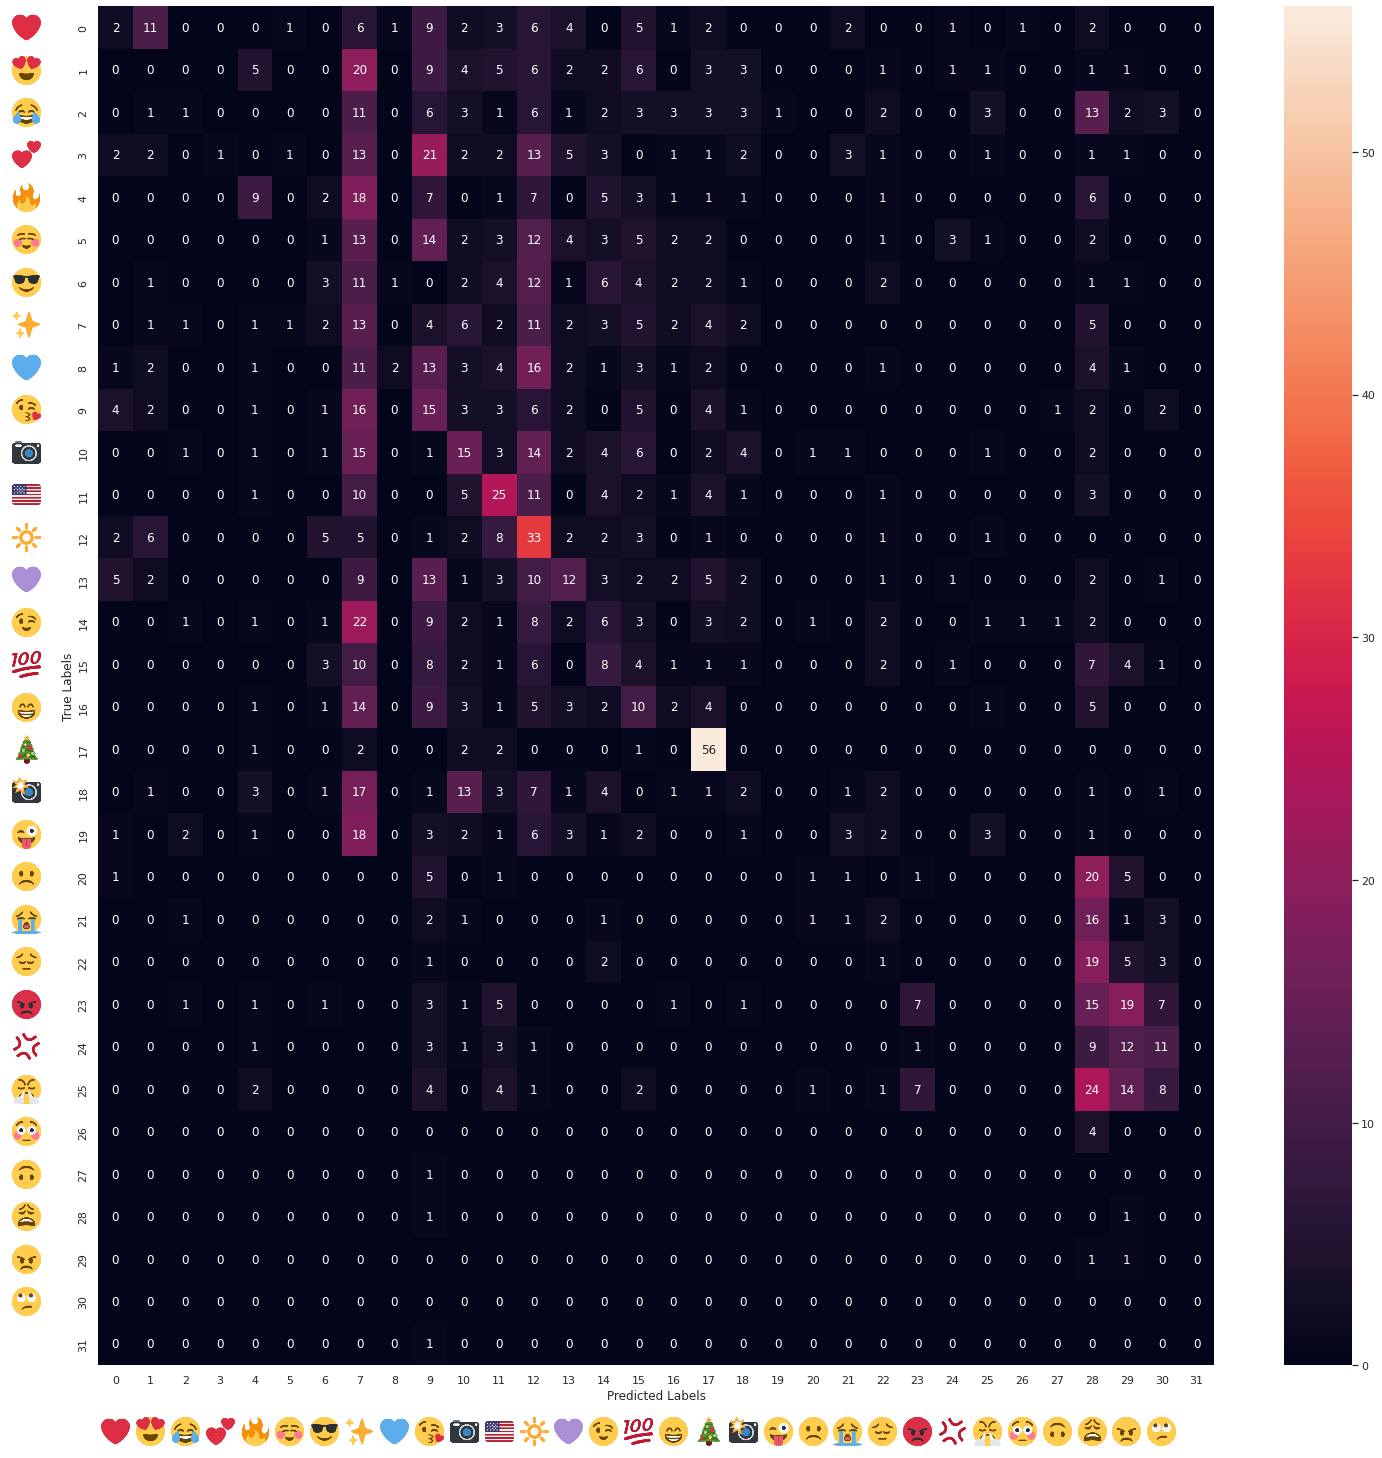

In [11]:
confusion_matrix_emojis(labels=references, predictions=predictions)

## 5. Evaluate Suggestions

In [12]:
precision_for_suggestions = precision_metric.compute(references=references, predictions=suggestions, average="micro")
print(f"Precision for the top {K} emoji's with highest probability:")
print(precision_for_suggestions)

Precision for the top 4 emoji's with highest probability:
{'precision': 0.33648393194706994}


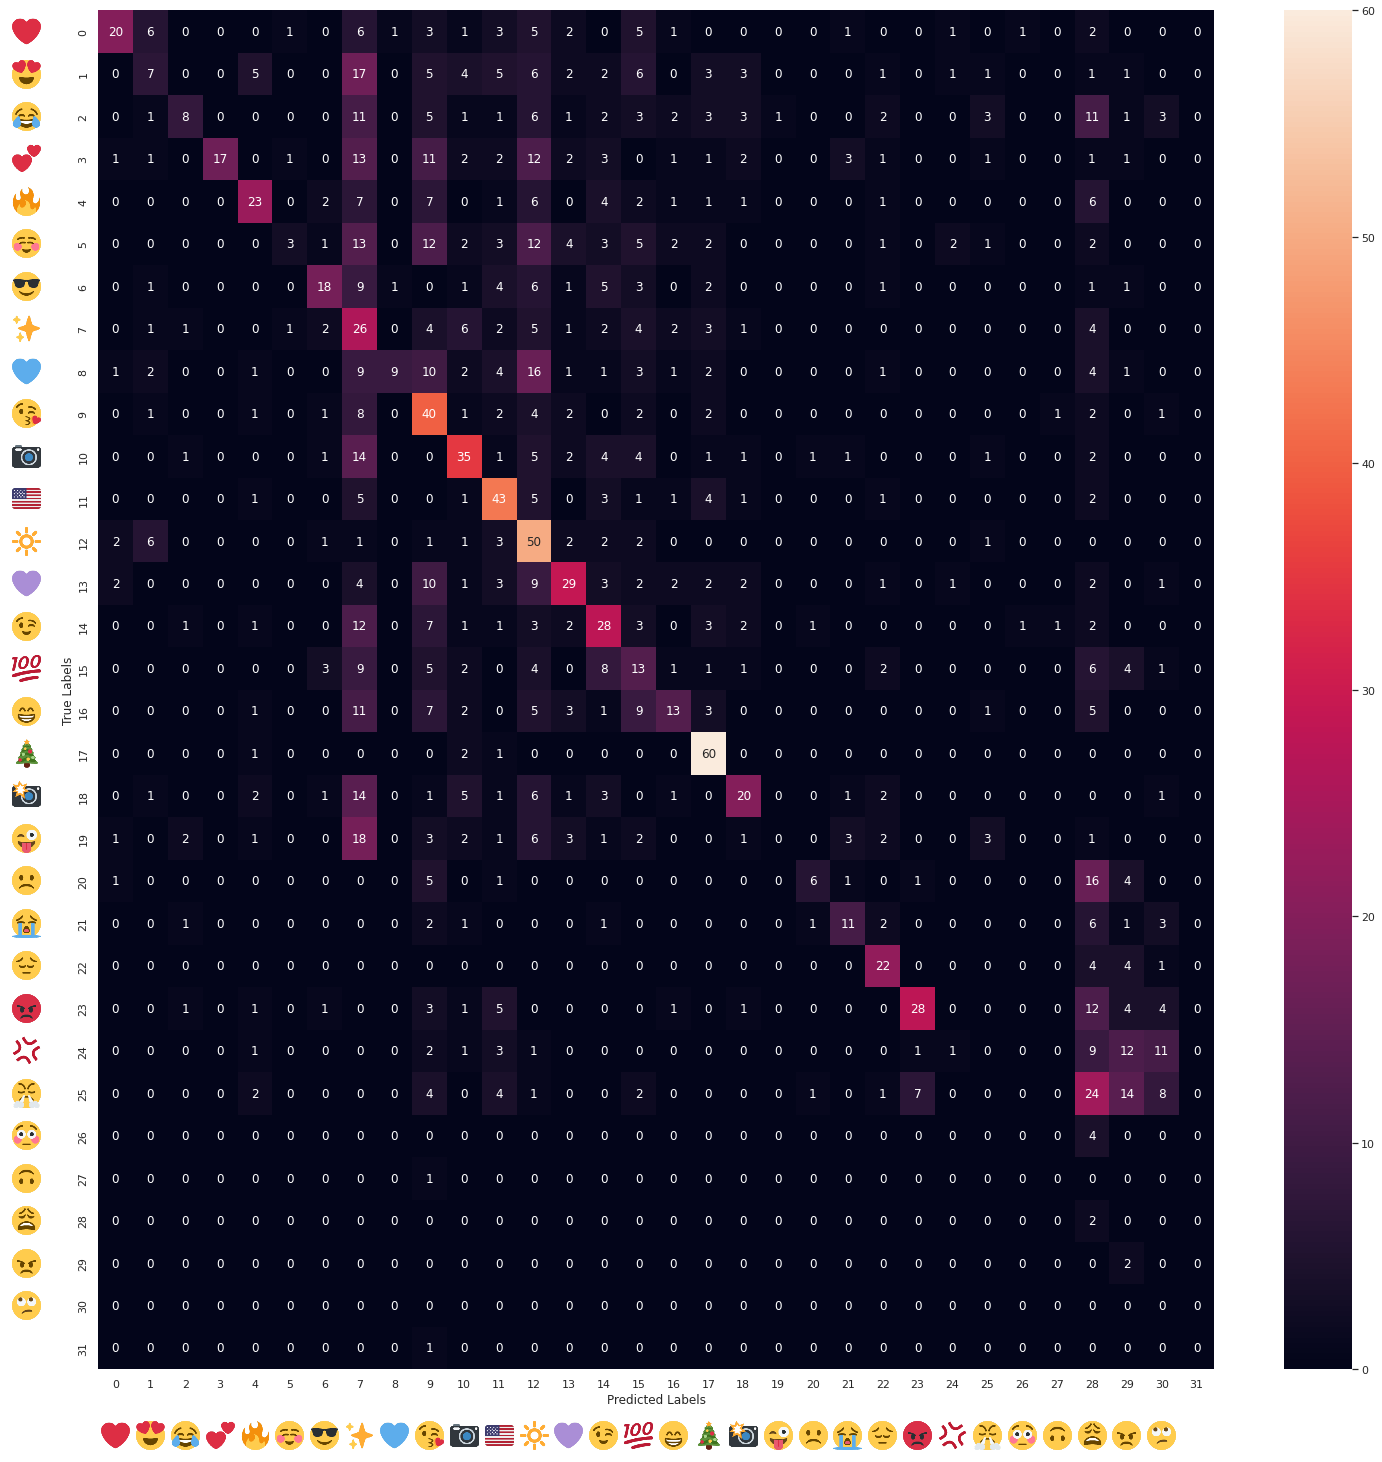

In [13]:
confusion_matrix_emojis(labels=references, predictions=suggestions)